# Write Neural Network from Scratch

TO DO: 
- Drop out layer
- Parameter Update
- Hyperparam optimization

<br/>
# 0. Generate some dataset

In [20]:
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
%matplotlib inline

In [36]:
X, y = make_moons(200, noise = 0.5)
print(X.shape, y.shape)

(200, 2) (200,)


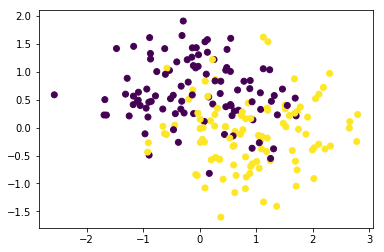

In [37]:
plt.scatter(X[:,0], X[:,1], c = y)

# 1. Define Gates (Add, Multiply)

## Notations
- WX --> **WX** <br/>
- WX + b --> **S** <br/>
- dL / d(WX) = **dWX ** <br/>
- dL / d(S) = **dS** <br/>

Math: http://cs231n.github.io/optimization-2/

In [158]:
class Mul:
    def forward(self, W, X):
        return np.dot(X, W)
    
    def backward(self, W, X, dWX):
        dW = np.dot( np.transpose(X), dWX )
        dX = np.dot( dWX, np.transpose (W))
        return dW, dX

In [159]:
class Add:
    def forward(self, WX, b):
        return WX + b

    def backward(self, WX, b, dS):
        dWX = dS * np.ones_like(WX)
        db = np.dot(np.ones((1, dS.shape[0]), dtype=np.float64), dS)
        return db, dWX

# 2. Define Activaton Functions (Sigmoid, Tanh, Softmax)

Activation(S)  --> **Z** <br/>
Input: 
dL / d(Z) = **dZ** <br/>
Output:
dL / d(S) = **dS** <br/>



In [160]:
class Tanh:
    def forward(self, S):
        Z = np.tanh(S)
        return Z
    
    def backward(self, S, dZ):
        Z = self.forward(S)
        dS = (1.0 - np.square(Z)) * dZ
        return dS

In [161]:
class Sigmoid:
    def forward(self, S):
        Z = 1.0 / (1.0 + np.exp(-S))
        return Z
    
    def backward(self, S, dZ):
        Z = self.forward(S)
        dS =(1 - Z) * Z * dZ
        return dS

$
\hat{y_{k}} = softmax(S_1, S_2, ..., S_{k}) \\
\mathbf{E} = - \sum_{i=1}^N y_{ik} log(\hat{y_{ik}} )\\
for\ each\ sample\ i: \\
\frac{\partial\mathbf{E}}{\partial S_{k}} = {\hat y}_{k} - y_{k},\ where\ y_{k} = 0, 1\\
$

In [162]:
class Softmax:
    # For Training
    def __init__(self):
        self.num_examples = 0
    
    def forward(self, S):
        self.num_examples = S.shape[0]
        exp_S = np.exp(S)
        Z = exp_S / np.sum(exp_S, axis = 1, keepdims = True)
        return Z

    def backward(self, S, y): # Note: y instead of dZ
        probs = Z = self.forward(S)
        for i in range(len(y)):
            true_label = y[i]
            probs[i][true_label] -= 1 # see equation above
        dS = probs
        return dS
    
    # For evaluation    
    def forward_loss(self, Z, y):
        probs = Z
        log_probs = []
        for prob, true_label in zip(probs, y):
            log_probs.append(np.log(prob[true_label]))
        avg_cross_entropy_loss = - 1.0 / self.num_examples * np.sum(log_probs) # see equation above
        return avg_cross_entropy_loss
    
    # For prediction
    def predict(self, Z):
        return np.argmax(Z, axis = 1)

### (Optional) Batch Normalization
- **Idea**: Normalize the inputs before activation function for each layer
- **Advantages**: Faster training; still allow scale and shift

<img src="https://kratzert.github.io/images/bn_backpass/bn_algorithm.PNG" width="400">

In [163]:
class BatchNorm:
    def __init__(self):
        self.cache = ()
        
    def forward(self, X, gamma, beta, eps):
        num_examples = X.shape[0]
        
        mu_B = 1.0 / num_examples * np.sum(X, axis = 0)
        X_mu = X - mu_B
        var_B = 1.0 / num_examples * np.sum(  X_mu ** 2, axis = 0 )
        sqrt_var_B = np.sqrt(var_B + eps)
        i_sqrt_var_B = 1. / sqrt_var_B
        X_hat =  X_mu * i_sqrt_var_B
        gammaX = gamma * X_hat
        DZ = gammaX + beta
        
        self.cache = (X_hat, X_mu, gamma, i_sqrt_var_B, sqrt_var_B, var_B, eps)
        return DZ
    
    def backward(self, dDZ):
        num_examples = dDZ.shape[0]
        X_hat, X_mu, gamma, i_sqrt_var_B, sqrt_var_B, var_B, eps = self.cache
        
        # scale and shift
        dbeta = np.sum(dDZ, axis = 0)
        dgammaX = dDZ
        dgamma = np.sum(dgammaX * X_hat, axis = 0)
        dXhat = dgammaX * gamma
        
        # Standardize
        di_sqrt_var_B = np.sum(dXhat * X_mu, axis = 0)
        d_x_mu_2 = dXhat * i_sqrt_var_B
        dsqrt_var_B = -1. / (sqrt_var_B ** 2) * di_sqrt_var_B
        dvar_B = 0.5 * 1. / np.sqrt(var_B + eps) * dsqrt_var_B

        # Batch variance
        dsquare = 1. / num_examples * np.ones_like(dDZ) * dvar_B
        d_x_mu_1 = 2 * X_mu * dsquare
        
        # Batch mean
        d_x_mu = d_x_mu_2 + d_x_mu_1 # d(f(x)g(x)) = f(x)g'(x) = f'(x)g(x)
        dmu = -1. * np.sum(d_x_mu, axis = 0)
        dx_2 = d_x_mu
        dx_1 = 1. / num_examples * np.ones_like(dDZ) * dmu
        dx = dx_2 + dx_1
        
        return dx, dgamma, dbeta

In [164]:
# Quick test:
print('Test for 1st input layer: Before normalization: ')
means = np.mean(network.layers[1].S, axis = 0)
stds = np.std(network.layers[1].S, axis = 0)
print('Mean/Std: ', means, stds) 
print('Test for 1st input layer: After normalization: ')
means = np.mean(network.layers[1].SZ, axis = 0)
stds = np.std(network.layers[1].SZ, axis = 0)
print('Mean/Std: ', means, stds) 

Test for 1st input layer: Before normalization: 
Mean/Std:  [-0.72121132 -0.57005132  1.27472341  1.07974379 -1.16385046] [ 0.82461969  0.87488978  0.86513178  0.39585403  0.71603479]
Test for 1st input layer: After normalization: 
Mean/Std:  [-0.78177444  0.04710461 -0.01692398 -0.34059753 -0.46412559] [ 1.25691133  0.64403428  1.10732488  0.95047386  0.94645352]


# 3. Define Layer

### Note: Weights initialization
- **All zero**: wrong: neuron outputs and gradients would be same; same update
- **Number to small**: small gradients for inputs; gradient diminishing for deep NN
- **All neuron with same output distribution**: w = np.random.randn(n) / sqrt(n), where n is number of inputs
    - It can be proved that Var(S) = Var(WX) = Var(X)

In [264]:
class Layer:
    def __init__(self, activation_function, num_neurons, batch_norm = False):
        self.dim = num_neurons
        self.activation = activation_function
        self.batch_norm = batch_norm
        if batch_norm:
            self.batchnorm = BatchNorm()
        self.isfirst = False
        self.islast = False
        self.before = None

    def set_first_layer(self, input):
        self.isfirst = True
        self.X = input
        
    def set_last_layer(self, y):
        self.islast = True
        self.y = y
    
    def initialize_Wb(self):
        if self.isfirst:
            before_dim = self.X.shape[1]
        else:
            before_dim = self.before.dim
        self.W = np.random.randn(before_dim, self.dim) / np.sqrt(before_dim) # see notes above
        self.b = np.random.randn(self.dim).reshape(1, self.dim) # see notes above
        if(self.batch_norm):
            self.gamma, self.beta = (1., 0.)
        
    def forward_propagation(self):
        if not self.isfirst:
            self.X = self.before.Z
        self.WX = Mul().forward( self.W, self.X )
        self.S = Add().forward( self.WX, self.b)
        if self.batch_norm:
            self.SZ = self.batchnorm.forward( self.S, self.gamma, self.beta, eps = 0)
            self.Z = self.activation.forward(self.SZ)
        else:
            self.Z = self.activation.forward(self.S)
            
        
    def backward_propagation(self):
        if self.islast:
            self.dS = self.activation.backward(self.S, self.y)
        else:
            if self.batch_norm:
                self.dSZ = self.activation.backward(self.SZ, self.dZ)
                self.dS, self.dgamma, self.dbeta = self.batchnorm.backward(self.dSZ)
            else:
                self.dS = self.activation.backward(self.S, self.dZ)

        self.db, self.dWX = Add().backward(self.WX, self.b, self.dS)
        self.dW, self.dX = Mul().backward(self.W, self.X, self.dWX)
        if not self.isfirst:
            self.before.dZ = self.dX

    def update_weight(self, learning_rate, lambda_):
        self.b += -learning_rate * self.db
        self.W += -learning_rate * self.dW + (- lambda_ * self.W)
        if self.batch_norm:
            self.gamma += -learning_rate * self.dgamma
            self.beta  += -learning_rate * self.dbeta
            
    # Only for softmax layer
    def print_loss(self, iteration):
        loss = self.activation.forward_loss(self.Z, self.y)
        print('The loss at iteration ', iteration, ' is: ' , loss)
        
    def predict(self):
        return self.activation.predict(self.Z)

# 4. Define Network

In [265]:
class Network:
    def __init__(self):
        self.layers = []
        self.input = []
        self.y = []
        
    def add(self, new_layer):
        if self.layers:
            new_layer.before = self.layers[-1]
        self.layers.append(new_layer)
    
    def load_data(self, input, y):
        self.layers[0].set_first_layer(input)
        self.layers[-1].set_last_layer(y)
        
    def initialize(self, input, y, batch_size):
        self.input = input
        self.y = y
        self.load_data(input[:batch_size,:], y[:batch_size])
        for layer in layers:
            layer.initialize_Wb()

    def train(self, num_iter, learning_rate, batch_size, lambda_ = 0):
        for i in range(num_iter):
            
            # Calculate batch index
            idx = np.random.randint(self.input.shape[0], size = batch_size)
            self.load_data(self.input[idx,:], self.y[idx])
            
            # Forward Propagation
            for layer in self.layers:
                layer.forward_propagation()
                
            # Print Loss
            if (i % 50 == 0):
                layers[-1].print_loss(i)
            
            # Backward Propagation
            for layer in self.layers[::-1]:
                layer.backward_propagation()
                layer.update_weight(learning_rate, lambda_ = lambda_ )
                
    def predict(self, X):
        self.layers[0].set_first_layer(X)
        for layer in self.layers:
            layer.forward_propagation()
        return layers[-1].predict()

# 5. Design Test Network

In [274]:
np.random.seed(1)
network = Network()
layers = []

In [275]:
network = Network()
layers.append(Layer(activation_function = Tanh(), num_neurons = 5, batch_norm = True))
layers.append(Layer(activation_function = Tanh(), num_neurons = 5, batch_norm = True))
layers.append(Layer(activation_function = Softmax(), num_neurons = 2))
for layer in layers:
    network.add(layer)

In [276]:
X, y = make_moons(200, noise = 0.3)
batch_size = 200
network.initialize(input = X, y = y, batch_size = batch_size)

In [277]:
network.train(num_iter = 2000, learning_rate = 0.02, batch_size = batch_size, lambda_ = 0.011)

The loss at iteration  0  is:  0.854828573317
The loss at iteration  50  is:  0.2039168189
The loss at iteration  100  is:  0.345740676584
The loss at iteration  150  is:  0.275869392336
The loss at iteration  200  is:  0.394356418529
The loss at iteration  250  is:  0.262774458189
The loss at iteration  300  is:  0.197261170389
The loss at iteration  350  is:  0.176726605662
The loss at iteration  400  is:  0.191170480869
The loss at iteration  450  is:  0.192158334978
The loss at iteration  500  is:  0.238164575509
The loss at iteration  550  is:  0.128010545621
The loss at iteration  600  is:  0.319885242204
The loss at iteration  650  is:  0.206147753467
The loss at iteration  700  is:  0.229606831274
The loss at iteration  750  is:  0.257818214189
The loss at iteration  800  is:  0.196208847562
The loss at iteration  850  is:  0.360078184466
The loss at iteration  900  is:  0.181220193011
The loss at iteration  950  is:  0.309210148717
The loss at iteration  1000  is:  0.277698869

In [279]:
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

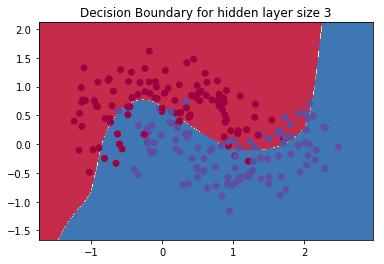

In [280]:
plot_decision_boundary(lambda x: network.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3")
plt.show()